<h1>Hierarchical Clusternig of 30 min data blocks</h1>
<p>In order to attempt to make better clusters we combined 30 minutes worth of data. For example a dishwasher wil use both water and electricity but not necessarily at exactly the same moment.</p>

In [1]:
%%bash
pip install -U scikit-learn

/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/pyth

In [2]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time

from opengrid.library import houseprint

from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:44166


In [3]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
30 Sites created
30 Devices created
87 sensors created
Houseprint parsing complete


In [4]:
hp??

In [4]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [5]:
#Get Electricity data
head = pd.Timestamp('20151114')
tail = pd.Timestamp('20151118')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [6]:
#Get Gas data
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_ga = gas.get_data(head,tail,diff=True)
df_ga = df_ga.dropna()

In [7]:
#Get Water data
water = hp.find_sensor('c57f45b21e2ec21ab427f172478e1ca4')
df_wa = water.get_data(head,tail,diff=True)
df_wa = df_wa.dropna()

<h3>Gas vs Water</h3>

In [8]:
#Concatinate the two datasets and drop lines with zero values
result = pd.concat([df_wa, df_ga], axis=1).dropna()
result.columns = ['water', 'gas']

<p>The duration of a block and the overlap of two blocks can be altered to have better results</p>

In [9]:
#Create new dataframe for cumulative consumption
df_gawa = pd.DataFrame({'gas' : [], 'water':[]})

df_loop = result
while (df_loop.size > 0):
    #Get timestamp of first row and take all rows between this time and 30 minutes later
    ts_start = df_loop.index[0]
    ts_end = (ts_start + 29)
    df_temporary = df_loop.ix[ts_start:ts_end]
    
    #Remove these first 30 minutes from the list
    df_loop = df_loop.ix[30:]
    
    #Sum these values and store them in the newely created dataframe
    df_gawa = df_gawa.append(pd.DataFrame([[df_temporary.sum()['gas'], df_temporary.sum()['water']]],index = [ts_start] , columns=df_gawa.columns))

    

In [10]:
df_gawa = df_gawa[~((df_gawa-df_gawa.mean()).abs()>3*df_gawa.std())]
df_gawa = df_gawa.dropna()

df_gawa['gas'] = df_gawa['gas']/df_gawa['gas'].max()
df_gawa['water'] = df_gawa['water']/df_gawa['water'].max()

In [11]:
#convert pandas to np array
resultArray = df_gawa.as_matrix()

In [12]:
#Run clustering Algorithm
ms = MeanShift()
ms.fit(resultArray)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

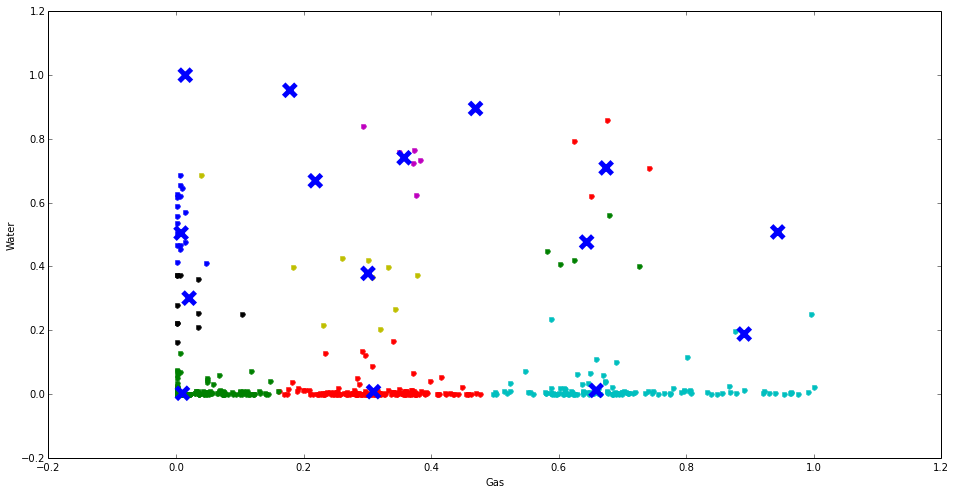

In [13]:
#Plot clusters
for i in range(len(resultArray)):
    plt.plot(resultArray[i][0], resultArray[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('Gas')
plt.ylabel('Water')
plt.show()

<h3>Electricity vs Water</h3>

In [282]:
#Concatinate the two datasets and drop lines with zero values
result = pd.concat([df_wa, df_el], axis=1).dropna()
result.columns = ['water', 'electricity']

<p>The duration of a block and the overlap of two blocks can be altered to have better results</p>

In [283]:
#Create new dataframe for cumulative consumption
df_elwa = pd.DataFrame({'electricity' : [], 'water':[]})

df_loop = result
while (df_loop.size > 0):
    #Get timestamp of first row and take all rows between this time and 30 minutes later
    ts_start = df_loop.index[0]
    ts_end = (ts_start + 29)
    df_temporary = df_loop.ix[ts_start:ts_end]
    
    #Remove these first 30 minutes from the list
    df_loop = df_loop.ix[30:]
    
    #Sum these values and store them in the newely created dataframe
    df_elwa = df_elwa.append(pd.DataFrame([[df_temporary.sum()['electricity'], df_temporary.sum()['water']]],index = [ts_start] , columns=df_elwa.columns))

    

In [284]:
#df_elwa = df_elwa[~((df_elwa-df_elwa.mean()).abs()>3*df_elwa.std())]
#df_elwa = df_elwa.dropna()

df_elwa['electricity'] = df_elwa['electricity']/df_elwa['electricity'].max()
df_elwa['water'] = df_elwa['water']/df_elwa['water'].max()

In [285]:
#convert pandas to np array
resultArray = df_elwa.as_matrix()

In [286]:
#Run clustering Algorithm
ms = MeanShift()
ms.fit(resultArray)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

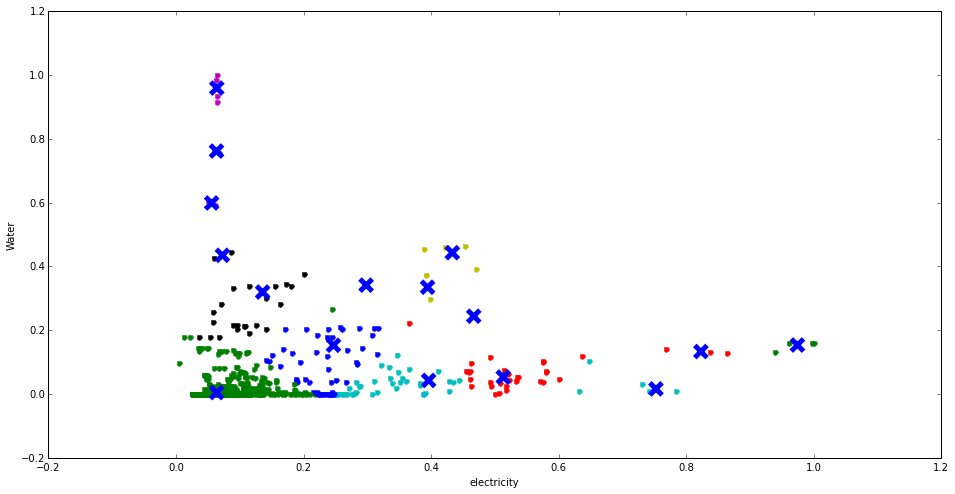

In [287]:
#Plot clusters
for i in range(len(resultArray)):
    plt.plot(resultArray[i][0], resultArray[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('electricity')
plt.ylabel('Water')
plt.show()

<h3>Electricity vs Gas</h3>

In [294]:
#Concatinate the two datasets and drop lines with zero values
result = pd.concat([df_ga, df_el], axis=1).dropna()
result.columns = ['gas', 'electricity']

<p>The duration of a block and the overlap of two blocks can be altered to have better results</p>

In [295]:
#Create new dataframe for cumulative consumption
df_elga = pd.DataFrame({'electricity' : [], 'gas':[]})

df_loop = result
while (df_loop.size > 0):
    #Get timestamp of first row and take all rows between this time and 30 minutes later
    ts_start = df_loop.index[0]
    ts_end = (ts_start + 29)
    df_temporary = df_loop.ix[ts_start:ts_end]
    
    #Remove these first 30 minutes from the list
    df_loop = df_loop.ix[30:]
    
    #Sum these values and store them in the newely created dataframe
    df_elga = df_elga.append(pd.DataFrame([[df_temporary.sum()['electricity'], df_temporary.sum()['gas']]],index = [ts_start] , columns=df_elga.columns))

    

In [296]:
#df_elwa = df_elwa[~((df_elwa-df_elwa.mean()).abs()>3*df_elwa.std())]
#df_elwa = df_elwa.dropna()

df_elga['electricity'] = df_elga['electricity']/df_elga['electricity'].max()
df_elga['gas'] = df_elga['gas']/df_elga['gas'].max()

In [297]:
#convert pandas to np array
resultArray = df_elga.as_matrix()

In [298]:
#Run clustering Algorithm
ms = MeanShift()
ms.fit(resultArray)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

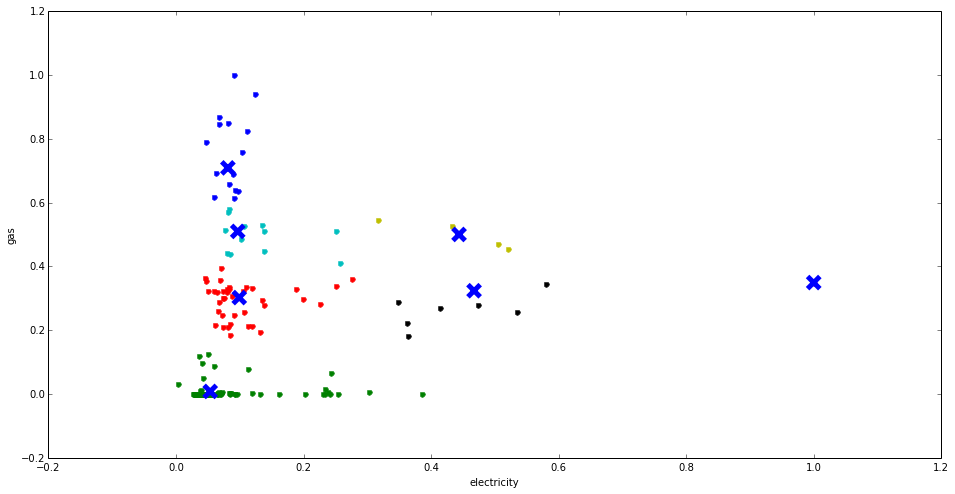

In [299]:
#Plot clusters
for i in range(len(resultArray)):
    plt.plot(resultArray[i][0], resultArray[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('electricity')
plt.ylabel('gas')
plt.show()